<a href="https://colab.research.google.com/github/shaktsin/coolml/blob/master/diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# imports
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn.functional as F
import torch.nn as nn

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shaktsin31","key":"541bf01e8c0aa37ce781a5d4fb91371e"}'}

In [3]:
!pip install -q kaggle

In [8]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [6]:
!kaggle datasets list

ref                                                              title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
stealthtechnologies/predict-student-performance-dataset          Predict Student Performance                          12KB  2024-12-26 12:57:04           1891         48  1.0              
anandshaw2001/mobile-apps-screentime-analysis                    Mobile Apps ScreenTime Analysis                       2KB  2024-12-31 18:20:51            778         24  1.0              
oktayrdeki/heart-disease                                         Heart Disease                                       568KB  2024-12-29 13:26:49           1464         37  1.0              
ankushpanday1/heart-attack-in-youth-of-india           

In [11]:
!kaggle datasets download -d uciml/pima-indians-diabetes-database

Dataset URL: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database
License(s): CC0-1.0
  0% 0.00/8.91k [00:00<?, ?B/s]
100% 8.91k/8.91k [00:00<00:00, 15.8MB/s]


In [22]:
!unzip pima-indians-diabetes-database.zip

Archive:  pima-indians-diabetes-database.zip
  inflating: diabetes.csv            


In [23]:
df = pd.read_csv("diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [24]:
features = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]
label = "Outcome"
X = df[features] # Features
y = df[f"{label}"] # Target variable

In [25]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 80% training and 20% test

In [26]:
# scaling data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
X_train.shape, X_test.shape

((614, 8), (154, 8))

In [27]:
g = torch.Generator().manual_seed(2147483647)

In [28]:
class Layer(nn.Module):
    def __init__(self, fan_in, fan_out, bias=False):
        super().__init__()
        self.bias = bias
        self.w = nn.Parameter(torch.randn((fan_in, fan_out), generator = g) / fan_in**0.5)
        self.b = nn.Parameter(torch.zeros(fan_out)) if self.bias else None

    def __call__(self, x):
        # x : B x D -> B batch and D feature dim
        # w : D x D1 -> D feature dimension and D1 - number of tensors in layer
        self.out = x @ self.w # B X D1
        if self.bias:
            self.out += self.b # B x D1
        return self.out

In [29]:
class Tanh(nn.Module):
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

In [53]:
m = nn.Sequential(
    Layer(8, 128, bias=True), Tanh(), # 8000 + 1000 - 9000
    Layer(128, 64, bias=True), Tanh(), # 400 + 400000 - 400400
    Layer(64, 2, bias=True), # 2 + 800
)
for p in m.parameters():
    p.requires_grad = True

In [31]:
X_Train = torch.Tensor(X_train)
X_Test = torch.Tensor(X_test)
Y_Train = torch.LongTensor(y_train.to_numpy())
Y_Test = torch.LongTensor(y_test.to_numpy())
X_Train.shape, X_Test.shape, Y_Train.shape, Y_Test.shape

(torch.Size([614, 8]),
 torch.Size([154, 8]),
 torch.Size([614]),
 torch.Size([154]))

In [34]:
# accuracy
def accuracy_fn(y_pred, y_true):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [54]:
# training
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(m.parameters(), lr=0.01)
torch.manual_seed(42)
epochs = 2000
lossTr = []
lossTe = []

for epoch in range(epochs):
    # put model in train mode
    m.train()

    optimizer.zero_grad()

    probs = m(X_Train)
    y_pred = probs.argmax(dim=1)

    loss = loss_fn(probs, Y_Train)
    acc = accuracy_fn(Y_Train, y_pred)
    lossTr.append(loss.item())


    loss.backward()
    optimizer.step()

    m.eval()

    with torch.inference_mode():
        probs_test = m(X_Test)
        y_test_pred = probs_test.argmax(dim=1)

        test_loss = loss_fn(probs_test, Y_Test)
        test_acc = accuracy_fn(Y_Test, y_test_pred)
        lossTe.append(test_loss.item())

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss.item():.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss.item():.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.77295, Acc: 46.91% | Test Loss: 0.61010, Test Acc: 69.48%
Epoch: 10 | Loss: 0.45020, Acc: 78.66% | Test Loss: 0.50591, Test Acc: 74.68%
Epoch: 20 | Loss: 0.42275, Acc: 80.29% | Test Loss: 0.53938, Test Acc: 76.62%
Epoch: 30 | Loss: 0.38878, Acc: 81.11% | Test Loss: 0.51522, Test Acc: 74.68%
Epoch: 40 | Loss: 0.33656, Acc: 84.85% | Test Loss: 0.54994, Test Acc: 73.38%
Epoch: 50 | Loss: 0.26406, Acc: 89.58% | Test Loss: 0.61505, Test Acc: 71.43%
Epoch: 60 | Loss: 0.18185, Acc: 94.63% | Test Loss: 0.69352, Test Acc: 68.83%
Epoch: 70 | Loss: 0.10951, Acc: 98.21% | Test Loss: 0.83562, Test Acc: 70.13%
Epoch: 80 | Loss: 0.06010, Acc: 99.51% | Test Loss: 0.98555, Test Acc: 70.78%
Epoch: 90 | Loss: 0.03320, Acc: 100.00% | Test Loss: 1.14353, Test Acc: 71.43%
Epoch: 100 | Loss: 0.01972, Acc: 100.00% | Test Loss: 1.26739, Test Acc: 71.43%
Epoch: 110 | Loss: 0.01287, Acc: 100.00% | Test Loss: 1.36930, Test Acc: 70.78%
Epoch: 120 | Loss: 0.00916, Acc: 100.00% | Test Loss: 1.4550

<Axes: >

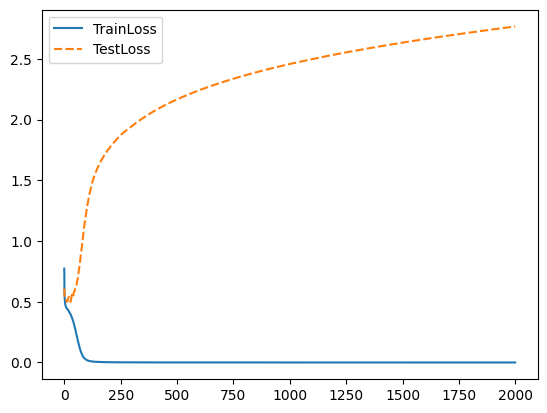

In [55]:
data = {'TrainLoss': lossTr, 'TestLoss': lossTe}
ldf = pd.DataFrame(data)
#ldf.to_csv('loss.csv', index=False)

#ldf = pd.DataFrame(losses, columns=['TrainLoss', 'TestLoss'])
sns.lineplot(data=ldf)

In [41]:
# evaluation
m.eval()
logits = m(X_Test)
probs = F.softmax(logits, dim=1)
ix = probs.argmax(dim=1)
acc = accuracy_fn(ix.view((154, )), Y_Test)
print(f" Test accurancy {acc:.2f}")

 Test accurancy 70.13
